# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [1]:
# Add your imports here
# Basic Package
import pandas as pd
import numpy as np
import scipy as sp

# Graphic Package
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# pyspark Package 
from pyspark.sql import *
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import FloatType
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

#### Task A:

1. First of all, we save the Spark dataframe in parquet format and use SQL command to filter ```dataframe``` where ```PostTypeId == 1``` and get the number of question ```num_question ```. 
2. Using the same method, we get the number of answers ```num_question ``` where  ```PostTypeId == 2```. 
3. Then we count the number of questions with score of 0 where ```PostTypeId == 1 and Score == 0``` to get the percentage of the 0 score by ```num_score_0.count() / num_question.count()```. 

In [ ]:
# Read the dataframe
file_path = './data/Posts.json'
df_post = spark.read.json(file_path)

In [ ]:
# Save the dataframe in Parquet format
df_post.write.mode('overwrite').parquet('Posts.parquet')

In [2]:
# Read the Parquet
parquet_post = spark.read.parquet('Posts.parquet')

In [3]:
parquet_post.show(3)

+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|2017-08-17T16:20:...|45740344|45740224|         2|    0|                null|                null|     null|
|2017-08-17T16:20:...|45740346|45739185|         2|    1|                null|                null|     null|
|2017-08-17T16:20:...|45740348|    null|         1|    2|<flash><react-nat...|Is it possible to...|      143|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
only showing top 3 rows



In [4]:
# Use SQL statement in a tempory view 
parquet_post.createOrReplaceTempView('parquet_post')

# The number of question asked in StackOverflow
sql_questoin = 'SELECT * FROM parquet_post WHERE PostTypeId == 1 '
num_question = spark.sql(sql_questoin)
count_question = num_question.count()
print('The number of questrion asked in StackOverflow is {:d}'
                                  .format(num_question.count()))
# The number of answers
sql_answer = 'SELECT * FROM parquet_post WHERE PostTypeId == 2'
num_answer = spark.sql(sql_answer)
print('The number of answers given in StackOverflow is {:d}'
                                  .format(num_answer.count()))

# The percentage of questions with a score of 0
sql_score_0 = 'SELECT *FROM parquet_post WHERE PostTypeId == 1\
                                           AND Score == 0 '
num_score_0 = spark.sql(sql_score_0)
print('The percentage of question with a score of 0 is {:0.2f}%'
                .format(100*num_score_0.count()/count_question))

The number of questrion asked in StackOverflow is 15647060
The number of answers given in StackOverflow is 25192772
The percentage of question with a score of 0 is 46.54%


**Hint:** Load the dataset from the Parquet file for the next tasks.

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

#### Task B.1: What is the proportion of tags that appear in fewer than 100 questions?

1. Firstly, we substring each row of Column ```Tags``` from ```sencond to last second``` alphabet by using our own defined ```UDF``` function.
2. Then we use ```f.split``` function to split the tag by ```'><'``` and get the each element of splitted array by ```f.posexplode``` function.

In [5]:
# Use SQL statement in a tempory view 
parquet_post.createOrReplaceTempView('parquet_post')

# Select Tags from question 
sql_tags = 'SELECT Tags FROM parquet_post WHERE PostTypeId == 1'
tags = spark.sql(sql_tags)

In [6]:
# Extract string from sencond to last second
udf1 = udf(lambda x:x[1:-1], StringType())
tags = tags.withColumn('substr',udf1('Tags'))
tags.show(2,False)

+---------------------------------+-------------------------------+
|Tags                             |substr                         |
+---------------------------------+-------------------------------+
|<flash><react-native>            |flash><react-native            |
|<postgresql><formatting><plpgsql>|postgresql><formatting><plpgsql|
+---------------------------------+-------------------------------+
only showing top 2 rows



In [7]:
# Split by '><' and get the tags, seperate tags are in 'val' column
tags_ravel = tags.select(
            f.split("substr", "><").alias("letter"),
            f.posexplode(f.split("substr", "><")).alias("pos", "val"))
tags_ravel.show(5,False)

+---------------------------------+---+------------+
|letter                           |pos|val         |
+---------------------------------+---+------------+
|[flash, react-native]            |0  |flash       |
|[flash, react-native]            |1  |react-native|
|[postgresql, formatting, plpgsql]|0  |postgresql  |
|[postgresql, formatting, plpgsql]|1  |formatting  |
|[postgresql, formatting, plpgsql]|2  |plpgsql     |
+---------------------------------+---+------------+
only showing top 5 rows



Then we calculate the proportion of tags that appear in fewer than 100 questions.

In [8]:
# Calulate the proportion
tag_count = tags_ravel.groupBy('val').count()
proportion = tag_count.filter('count < 100').count()/tag_count.count()
print("The proportion of tags that appear in fewer than 100 questions is : {p:.3f}%".format(p= 100*proportion))

The proportion of tags that appear in fewer than 100 questions is : 67.979%


#### Task B.2: Plot the distribution of the tag counts using an appropriate representation.

1. We sort the the spark dataframe by the number of tags and convert it to pandas.
2. Then we plot distribution of the tag counts in ```histogram```, ```histogram in log-log scale```, and ```cumulative count histogram```.
3. It is obvious that the distribution of counts is heavy-tailed and its log-log scale and cumulative style can help us to see clearly the relationship between the variables.

In [9]:
tag_count = tag_count.sort('count',ascending = False).cache()

In [10]:
# Convert Spark datadrame to panda dataframe
pd_tag_count = tag_count.toPandas()

Plot the typical histogram.

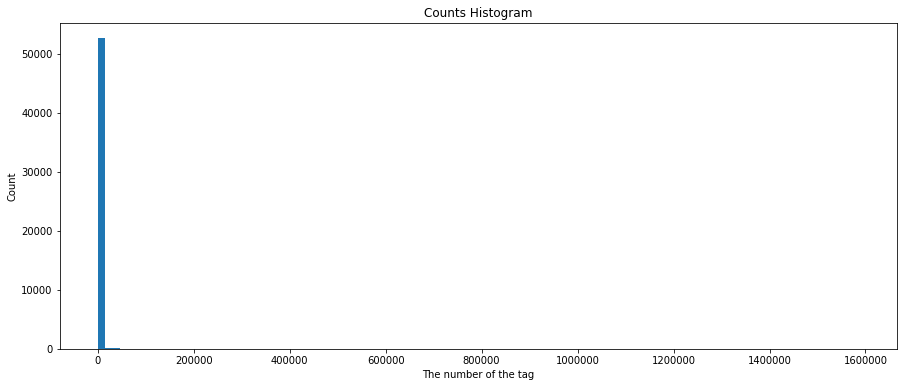

In [11]:
plt.figure(figsize=(15,6))
tags_counts_log, bin_edges, patches = plt.hist(pd_tag_count['count'],bins= 100)
plt.xlabel('The number of the tag')
plt.ylabel('Count')
plt.title('Counts Histogram')
plt.show()

Plot the log-log scale histogram.

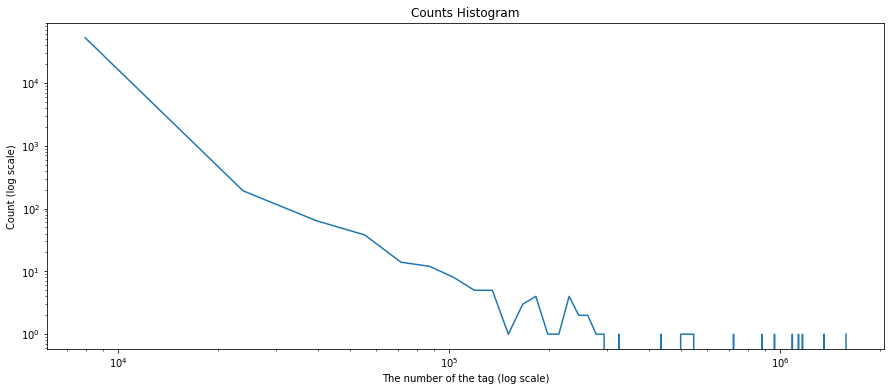

In [12]:
# the median of each bin
plt.figure(figsize=(15,6))
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
plt.loglog(bin_centers,tags_counts_log,'-')
plt.xlabel('The number of the tag (log scale)')
plt.ylabel('Count (log scale)')
plt.title('Counts Histogram')
plt.show()

Plot the cumulative histogram.

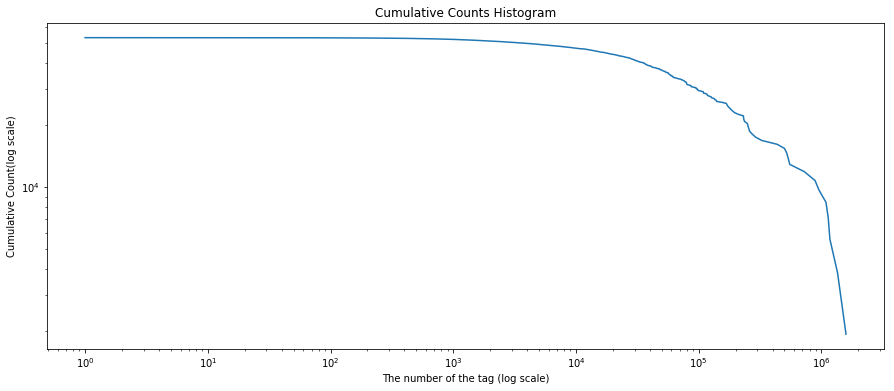

In [13]:
# get the counts of tags' counts
tag_value_counts = pd_tag_count["count"].value_counts()

# sort the counts and get the cumulative value
sorted_tag_value_counts    = tag_value_counts.sort_index()
cumulative_tag_value_counts= np.cumsum(sorted_tag_value_counts)[::-1]

# plot
plt.figure(figsize=(15,6))
plt.loglog(sorted_tag_value_counts.index,cumulative_tag_value_counts,'-')
plt.xlabel('The number of the tag (log scale)')
plt.ylabel('Cumulative Count(log scale)')
plt.title('Cumulative Counts Histogram')
plt.show()

⬆From the figures above, we know that:
1. There are a few tags (described by Count in figures) that have a extremely large numbers (more than 1600000) while most other tags have a amount less than 200000, which makes the Barplot 'Counts Histogram' almost accumulate in left side.
2. The scale looks better if we use log-log plot. In the left part of the log-log figure (the number of tag is less than ${10}^{5}$), we can see the figure approximate to a line, which means it closes to a power distribution when the number of tag less than ${10}^{5}$.

#### Task B.3: Plot a bar chart with the number of questions for the 10 most popular tags.

Simply plot the number of questions for the 10 most popular tags in sorted tag_count panda dataftrame by using ```sns.barplot```.

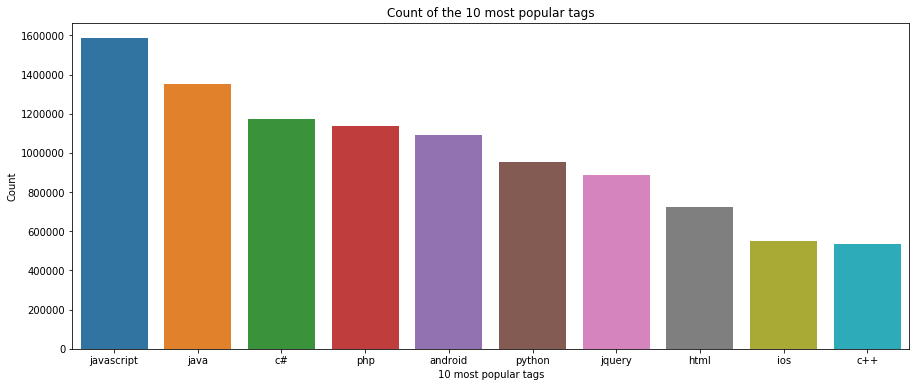

In [14]:
# Get the 10 most popular tags
pop_tags= pd_tag_count.loc[:9]

# Barplot
plt.figure(figsize=(15,6))
sns.barplot(x="val",y="count",data=pop_tags)
plt.xlabel('10 most popular tags')
plt.ylabel('Count')
plt.title('Count of the 10 most popular tags')
plt.show()

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

#### Task C.1 Get the view count and score of the questions with tag random-effects and visualize the relation between these two variables 

1. We filter the question (which are represented as ```PostTypedId == 1``` in the data-set);
2. We extract the tags with ```random-effects``` by using ```f.like```.

In [15]:
# Filter out the tags like 'random-effects' in question  
df_random_effects = parquet_post.where((f.col('PostTypeId') == 1) & (f.col('Tags').like('%<random-effects>%'))).cache()

# Select columns 'Viewcount','Score'
Viewcount_score =  df_random_effects.select(['Viewcount','Score'])
Viewcount_score.show(3,False)

+---------+-----+
|Viewcount|Score|
+---------+-----+
|12       |0    |
|495      |0    |
|220      |0    |
+---------+-----+
only showing top 3 rows



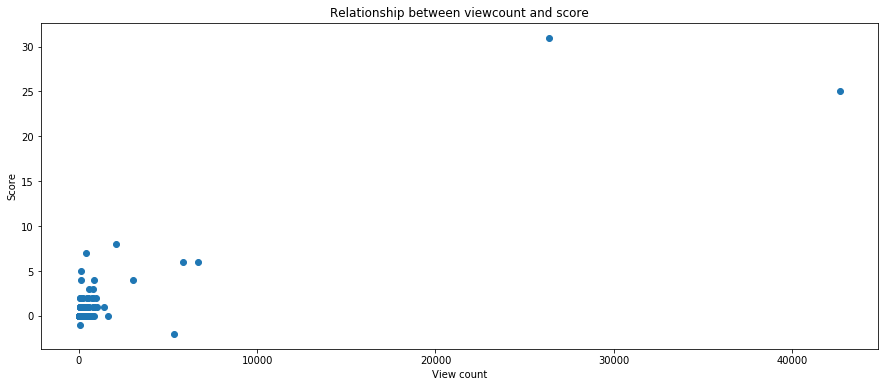

In [16]:
# Convert to pandas dataframe
df_view_score = Viewcount_score.toPandas()
data_plot = df_view_score.values

# Plot
plt.figure(figsize=(15,6))
plt.scatter(data_plot[:,0],data_plot[:,1])
plt.xlabel('View count')
plt.ylabel('Score')
plt.title('Relationship between viewcount and score')
plt.show()

⬆From the scatter figure, we can see that:
1. most points acumulate in left corner and only two points have very large Viewcount values and Socre.
2. We could not see a strong linear relation between Viewcount and Score since the sactters are random and disordered.

#### Task C.2 Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

In [17]:
print("The Pearson coeffient of these two variables is {:0.2f}".format(df_view_score.corr().iloc[0,1]))
df_view_score.corr()

The Pearson coeffient of these two variables is 0.88


,Viewcount,Score
Viewcount,1.000000,0.882197
Score,0.882197,1.000000


⬆From above, we can conclude that: 
1. The Pearson coeffient of these two variables is 0.88 (>0.7), which means that these two variables have strong linear relation in pearson view. 
2. However, when we look at the scatter plot above, it is shown that there is no obvious linear relationship between these two variables. 
3. Therefore, we can confirm that these two variables are not correlated and the pearson coeffient give us a spurious correlations.

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python. Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


#### Taks D.1 Get the response time for the first answer of the questions with the tags python and java.

For Tag ```python```:
1. We firstly filter question with tags pyhton by using ```PostTypeId == 1``` and ``` f.col('Tags').like('%<python>%')```, and filter answer by using```f.col('PostTypeId') == 2```.
2. we inner join the question dataframe and answer dataframe when ```answer.ParentId == question.Id``` to get a joined dataframe (```python_q_a```) consisting information of questions and answers.
3. we convert the ```CreationDate``` of question and the ```CreationDate``` of answer into ```seconds``` by ```f.unix_timestamp```, and compute the difference of time to get the response time.
4. At last, we group according to ```ParentId``` and aggregate the fastest response by finding ```minimun``` value of the response time for each ParentId.

In [18]:
# Filter question and tags 'python', we use 'like' function to filter them out
python_question = parquet_post.where((f.col('PostTypeId') == 1) & (f.col('Tags').like('%<python>%'))).cache()

# Filter answer
python_answer = parquet_post.where((f.col('PostTypeId') == 2)).cache()
    
# Selcet interested columns 'CreationDate','Id','ParentId','Tags'
python_a = python_answer.select(['CreationDate','Id','ParentId','Tags']).cache()

# Rename columns names for dataframe 'question'
python_q = python_question.select(f.col('CreationDate')\
                          .alias('CreationDate_q'),f.col('Id')\
                          .alias('Id_q'), f.col('Tags')\
                          .alias('Tags_q'))

# Inner join the question with answer dataframe when answer.ParentId == question.Id
python_q_a = python_a.join(python_q, python_a.ParentId == python_q.Id_q).cache()

timeFmt = "yyyy-MM-dd'T'HH:mm:ss.SSSXXX"

# Convert the timestamp into second and compute the difference of time
timeDiff = (f.unix_timestamp('CreationDate', format=timeFmt)
            - f.unix_timestamp('CreationDate_q', format=timeFmt))

# Add a column to store the difference of time
python_q_a = python_q_a.withColumn('Time_diff',timeDiff )

# For each question, match their first response time 
python_time_diff = python_q_a.groupBy(f.col('ParentId'))\
                             .agg(f.min('Time_diff')
                             .alias('Response time'))\
                             .sort('Response time', ascending = False)\
                             .cache()

python_time_diff.show(5)

+--------+-------------+
|ParentId|Response time|
+--------+-------------+
| 3211079|    246457525|
| 4190667|    226585265|
| 4913561|    226468012|
| 4746726|    222563291|
| 5212950|    222405003|
+--------+-------------+
only showing top 5 rows



For Tag ```java``` , in the same way:
1. We firstly filter question with tags pyhton by using ```PostTypeId == 1``` and ``` f.col('Tags').like('%<java>%')```, and filter answer by using```f.col('PostTypeId') == 2```.
2. We inner join the question dataframe and answer dataframe when ```answer.ParentId == question.Id``` to get a joined dataframe ```python_q_a```.
3. We convert the ```CreationDate``` of question and the CreationDate of answer into ```seconds``` by ```f.unix_timestamp```, and compute the difference of time to get the response time.
4. At last, we ```groupby``` columns```ParentId``` and aggregate by finding ```minimun``` value of the response time for each ParentId.

In [19]:
# Filter question and tags 'java', we use 'like' function to filter them out
java_question = parquet_post.where((f.col('PostTypeId') == 1) & (f.col('Tags').like('%<java>%'))).cache()

# Filter answer
java_answer = parquet_post.where((f.col('PostTypeId') == 2)).cache()

# Selcet interested columns 'CreationDate','Id','ParentId','Tags'
java_a = java_answer.select(['CreationDate','Id','ParentId','Tags']).cache()

# Rename columns names for dataframe 'question'
java_q   =   java_question.select(f.col('CreationDate')\
                          .alias('CreationDate_q'), f.col('Id')\
                          .alias('Id_q'), f.col('Tags')\
                          .alias('Tags_q'))

# Inner join the question with answer dataframe when answer.ParentId == question.Id
java_q_a = java_a.join(java_q, java_a.ParentId == java_q.Id_q).cache()

# Add a column to store the difference of time
java_q_a = java_q_a.withColumn('Time_diff',timeDiff )

# For each question, match their first response time 
java_time_diff = java_q_a.groupBy(f.col('ParentId'))\
                         .agg(f.min('Time_diff')
                         .alias('Response time'))\
                         .sort('Response time', ascending = False)\
                         .cache()

java_time_diff.show(5)

+--------+-------------+
|ParentId|Response time|
+--------+-------------+
|  545047|    298536705|
|  320049|    275219195|
| 2043532|    264006756|
| 1458393|    254851846|
| 2674135|    246315763|
+--------+-------------+
only showing top 5 rows



#### Task D.2 Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.

In [20]:
# Convert to panda dataframe
pd_python = python_time_diff.toPandas()
pd_java = java_time_diff.toPandas()

# Filter out the response time < 0
plot_python = pd_python[pd_python.iloc[:,1]>0]
plot_java   = pd_java[pd_java.iloc[:,1]>0]

We use log-log scale to plot the distribution for these two tags as their counts are shown in the power-law distribution in the origin histogram.

For Tag ```python```: 

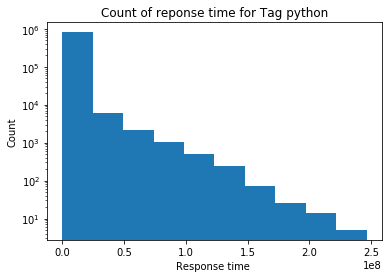

In [21]:
ax = plot_python['Response time'].plot(kind="hist",bins=10)
ax.set_yscale('log')
plt.xlabel('Response time ')
plt.ylabel('Count')
plt.title('Count of reponse time for Tag python')
plt.show()

⬆ From the figure, we know that:
1. The distribution is shown that there are a lot of answers shown in a very short time. 
2. It drops sharply around 0.25 and the counts of response in a long time are extremely few.

In [22]:
# show the mean, median, standard deviation of the counts of tags of python using describe()
plot_python.iloc[:,1].describe()

count    8.278480e+05
mean     9.837172e+05
std      6.908426e+06
min      1.000000e+00
25%      4.250000e+02
50%      1.357000e+03
75%      9.583000e+03
max      2.464575e+08
Name: Response time, dtype: float64

⬆ As shown above:
1. The mean of the counts of python's questions is $9.837172 \times 10^5$ while the median is $1.357 \times 10^3$ which is much smaller. 
2. And the stadard deviation is $6.908426 \times 10^6$, which indicates that the difference of counts is large or the ouliers have a strong influence on the statistic.

For Tag ```java```:

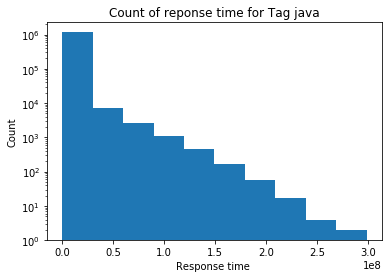

In [23]:
ax = plot_java['Response time'].plot(kind="hist",bins=10)
ax.set_yscale('log')
plt.xlabel('Response time ')
plt.ylabel('Count')
plt.title('Count of reponse time for Tag java')
plt.show()

⬆  From the figure, we know that:
1. The distribution is shown similar to that of python.There are also a lot of answers shown in a very short time while the counts of response in a long time are extremely few. 
2. The sharp drop also appear around 0.25. But the figure of longest response time seem to be much larger than that of python.

In [24]:
# show the mean, median, standard deviation of the counts of tags of python using describe()
plot_java.iloc[:,1].describe()

count    1.176818e+06
mean     9.988756e+05
std      7.133064e+06
min      1.000000e+00
25%      3.960000e+02
50%      1.224000e+03
75%      9.615000e+03
max      2.985367e+08
Name: Response time, dtype: float64

⬆ As shown above:
1. The mean of the counts of java's tags is very large ($9.988756 \times 10^5$) while the median is much smaller($1.224000 \times 10^3$). 
2. The standrad deviation is also very large, which also indicates that the difference of the counts is very large  or the ouliers have a strong influence on the statistic. 
3. We can also see that the mean and stardard variance of response time of queations related to Java is higher than that of Python  while the median is smaller.

#### Task D.3 We believe that the response time is lower for questions related to Python. Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.

We want to confirm the assumption (the response time is lower for questions related to Python), that is to say, we want to contradict the opposite assumption (the response time is faster or equal to questions related to Python), so we set the null Hypothesis is latter, and the test Hypothesis is former.<br/>
<br/>
$H_0$: the response time is faster or equal to questions related to Python<br/>
$H_1$: the response time is lower for questions related to Python

We define the set of Python is $X$ and the set of Java is $Y$.<br/>
As the mean of $X$ and $Y$ is bias, so we use median( denoted as $\theta$ ) to measure the response time of the Python's set( $\theta_0$ ) and the Java's set( $\theta_1$ ), i.e.:<br/><br/>
<center>
    $H_0$ : $\theta_0 \geq \theta_1$<br/>
    $H_1$ : $\theta_0 < \theta_1$
</center>

We do the Hypothesis Boostrapping in the following step:<br/>
1. Calculate the test statistic ${\displaystyle t=\theta_0 -\theta_1}$ 
2. Draw a random sample ( ${\displaystyle x_{i}^{*}}$ ) of size ${\displaystyle n}$  with replacement from ${\displaystyle x_{i}}$ and another random sample ( ${\displaystyle y_{i}^{*}}$ ) of size ${\displaystyle m}$ with replacement from ${\displaystyle y_{i}}$.
3. Calculate the median of new data set ${\displaystyle x^{*}}$ as  $\theta_0^{*}$ and ${\displaystyle y^{*}}$ as  $\theta_1^{*}$
4. Calculate the test statistic ${\displaystyle t^{*}=\theta_0^{*} - \theta_1^{*}} $
5. Repeat 3 and 4 ${\displaystyle B}$ times ( ${\displaystyle B=10000}$ in this case) to collect ${\displaystyle B}$ values of the test statistic.<br/>
6. We need to calculate the lowerbound of the p-value<br/>
Estimate the p-value as ${\displaystyle p={\frac {\#\{t^{*} < -t\} +1}{B+1}}}$ (According to what is said by  [Rick Wicklin](https://blogs.sas.com/content/iml/2011/11/02/how-to-compute-p-values-for-a-bootstrap-distribution.html), to eliminate the bias due to the finite sampling, we add one both on the numerator and denominator)

In [25]:
# define the X and Y set
x=plot_python['Response time'].values
y=plot_java['Response time'].values

#compute the median of x and y
x_mid=np.median(x)
y_mid=np.median(y)
print("The median of python response time is {m}".format(m=x_mid))
print("The median of java response time is {m}".format(m=y_mid))

# compute the size of set X and set Y
m=len(x)
print("The size of python response time is : {s}".format(s=m))
n=len(y)
print("The size of java response time is : {s}".format(s=n))

t_statistic=x_mid-y_mid
print("The test statistic is {t}".format(t=t_statistic))

The median of python response time is 1357.0
The median of java response time is 1224.0
The size of python response time is : 827848
The size of java response time is : 1176818
The test statistic is 133.0


In [27]:
def create_new_dataset(x_origin,n):
    """
    Create a new data set for boostrapping.

    :Argument:
    param1 (x_origin): the original data-set
    param2 (n): the size of the data-set

    :Return: the new data-set (if the size of the new set is correct)
            or
            None (print out the error announcement)
    """
    # randomly choose n samples from the original set with replacement
    x_new=np.random.choice(x_origin,n)
    if len(x_new)==n:
        return x_new
    else:
        print("Create new dataset failed")
        print(len(x_new))

def hypothesis_boostrapping(times):
    """
    Do hypothesis boostrapping.
    
    :Argument:
    param (times): the times of doing hypothesis boostrapping
    
    :Return: p-value
             mid_diff : List of the median difference between python and java
    """
    mid_diff=[]
    t_cardinality=0
    for i in range(times):
#         print("{i}th-time :".format(i=i+1))
        # Create new data-set according to X and Y
        x_new=create_new_dataset(x,m)
        y_new=create_new_dataset(y,n)
#         x_new=np.asarray(x_new)
#         y_new=np.asarray(y_new)
        # Compute the mean and variance of the new data-set
        x_new_mid=np.median(x_new)
        y_new_mid=np.median(y_new)
        # Compute the new test satistic
        t_star= x_new_mid - y_new_mid
        mid_diff.append(t_star)
#         print("t-star is : {t_s} while t is {t}".format(t_s=t_star,t=t))
        if (t_star < -t_statistic):
            # If t-star satisfy the null hypothesis is true, add into the count set.
            # This count set is for the culculation of the p-value
            t_cardinality = t_cardinality+1
#         print("t_cardinality is {c}".format(c=t_cardinality))
    p=(t_cardinality+1)/(times+1)
    return p,mid_diff

In [29]:
# run the hypothesis boostrapping 10000 times.
p,mid_diff=hypothesis_boostrapping(10000)
print("p-value is {p}".format(p=p))

p-value is 9.999000099990002e-05


⬆From above, we know that:
1. As we can see that the p-value is $9.999 \times 10^{-5}$ which is lower than $\alpha = .05$, we can reject the null hypothesis. 
2. Therefore, we can confirm the test hypothesis, which means that the response time related to Java is exactly lower for questions related to Python.

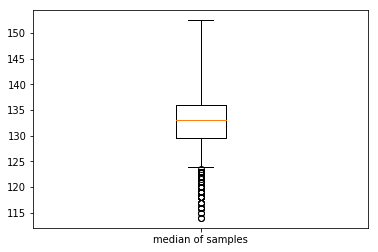

In [30]:
# plot the confidence interval
plt.boxplot(mid_diff, whis=[5,100], labels =['median of samples'],sym='o')
plt.show()

⬆From the figure above, we know that:
1. The difference between the median response time of Python and the median response time of Java (median(Python) - median(Java)) is at least more than 100.
2. Most of the difference value of the median is between 124 to 153.
3. Even the outliers are still larger than 0, which means that the response time related to Java is exactly lower for questions related to Python. And that is consistent with the very small p-value($9.999 \times 10^{-5}$)

#### Task D.4 Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.

1. First of all, we inner join the spark dataframes of questions and answers using ```answer.ParentId == question.Id```.
2. We convert the ```CreationDate``` of questions and the ```CreationDate``` of answers into ```seconds``` by ```unix_timestamp```, and compute the difference of time to get the response time. 
3. Calculate the shortest reponse time for each question.
4. Then, we seperate the tags of questions as we did before and group questions according to these tags. We ```groupby``` columns```Tags``` and aggregate them by finding ```avg```  and ```median``` values of the response time for each Tags.
5. Finally, we convert the data whose tags are ```larger than 5000``` to pandas dataframe and plot distribution.

In [31]:
# inner join the spark dataframes of questions and answers 
parquet_Q = parquet_post.filter('PostTypeId = 1')\
                           .select('Id', 'Tags', parquet_post.CreationDate.alias('CreationDate_Q'))
parquet_A = parquet_post.filter('PostTypeId = 2')\
                           .select('ParentId', parquet_post.CreationDate.alias('CreationDate_A'))
parquet_QA = parquet_A.join(parquet_Q, parquet_A.ParentId==parquet_Q.Id).cache()
# convert the CreationDate of question and the CreationDate of answer into seconds
parquet_QA = parquet_QA.withColumn(
    "CreationDate_A", unix_timestamp('CreationDate_A', "yyyy-MM-dd'T'HH:mm:ss.SSSXXX")).cache()
parquet_QA = parquet_QA.withColumn(
    "CreationDate_Q", unix_timestamp('CreationDate_Q', "yyyy-MM-dd'T'HH:mm:ss.SSSXXX")).cache()
# compute the difference of time to get the response time
parquet_QA = parquet_QA.withColumn('Response_time', parquet_QA.CreationDate_A - parquet_QA.CreationDate_Q) 
parquet_QA = parquet_QA.filter('Response_time >= 0')
# calculate the shortest reponse time for each question
parquet_QA = parquet_QA.groupBy('Id')\
                       .agg(min('Response_time').alias('Resp_time_min'))
parquet_Q_temp = parquet_Q.select(parquet_Q.Id.alias('Id1'), 'Tags')
parquet_QA = parquet_QA.join(parquet_Q_temp, parquet_QA.Id==parquet_Q_temp.Id1)
parquet_QA = parquet_QA.select('Id', 'Resp_time_min', 'Tags')
# seperate the tags of questions
# use rdd.map to seperate the tags
SOF_rdd_Tags = parquet_QA.rdd\
                         .map(lambda line:[line.Id, line.Resp_time_min, line.Tags.strip('<').strip('>').split('><')])
# flatMap can make one input to several outputs
SOF_rdd_Tags = SOF_rdd_Tags.flatMap(lambda line:[[line[0], line[1], tag] for tag in line[2]])
# convert rdd back to dataframe
SOF_Tags_df = SOF_rdd_Tags.toDF(['Id', 'Resp_time_min','Tags'])
# here we use self-defined function to calculate median
def median(values_list):
    med = np.median(values_list)
    return float(med)
udf_median = f.udf(median, FloatType())
SOF_Tags_df = SOF_Tags_df.groupBy('Tags')\
                         .agg(count('*').alias('Tags_Num'), 
                              avg('Resp_time_min').alias('Average_time'), 
                              udf_median(f.collect_list(col('Resp_time_min'))).alias('Median_time')).cache()
# choose appear at least 5000 times
SOF_Tags_df = SOF_Tags_df.filter('Tags_Num > 5000')
SOF_Tags_df = SOF_Tags_df.sort('Tags_Num', ascending = False)
SOF_Tags_df.show(5)

+----------+--------+------------------+-----------+
|      Tags|Tags_Num|      Average_time|Median_time|
+----------+--------+------------------+-----------+
|javascript| 1385837| 754539.2306591612|      968.0|
|      java| 1179059| 997091.0639331874|     1218.0|
|        c#| 1037397| 885841.1451170574|     1112.0|
|       php|  998582| 766199.6645072713|      845.0|
|   android|  902523|1713097.2613440321|     1629.0|
+----------+--------+------------------+-----------+
only showing top 5 rows



Plot the distribution of Average_time and Median_time

Text(0.5,1,'Distribution of 10 tags with the fastest median response time')

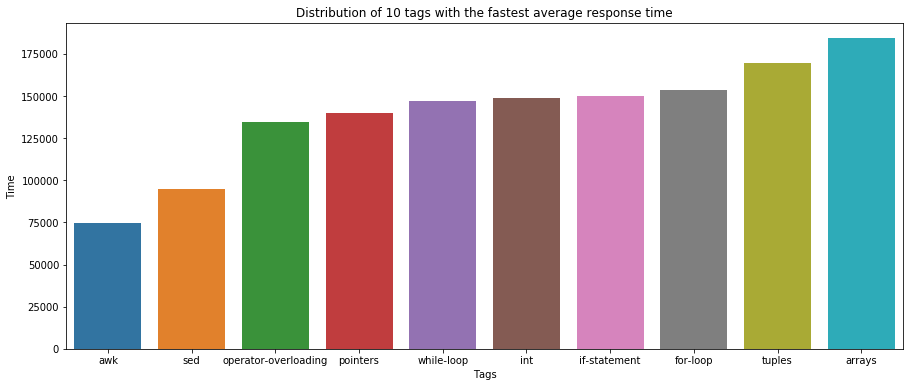

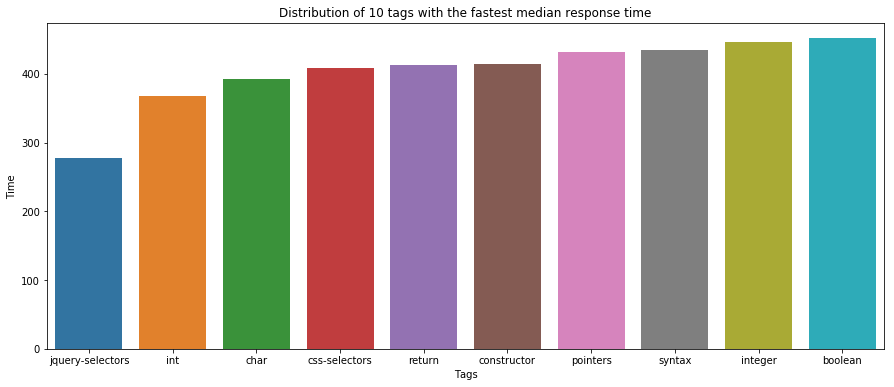

In [32]:
# Plot the distribution of Average_time and Median_time
SOF_Tags_pd = SOF_Tags_df.toPandas()

Tags_pd_avg = SOF_Tags_pd.sort_values(by= ['Average_time']).iloc[0:10]
plt.figure(figsize=(15,6))
sns.barplot(x='Tags',y='Average_time', data=Tags_pd_avg)
plt.xlabel('Tags')
plt.ylabel('Time')
plt.title('Distribution of 10 tags with the fastest average response time')

Tags_pd_Med = SOF_Tags_pd.sort_values(by= ['Median_time']).iloc[0:10]
plt.figure(figsize=(15,6))
sns.barplot(x='Tags',y='Median_time', data=Tags_pd_Med)
plt.xlabel('Tags')
plt.ylabel('Time')
plt.title('Distribution of 10 tags with the fastest median response time')

⬆From figures shown above, we know that:
1. The fastest respones time calculated by taking the smallest average response time of each tag is significantly larger than that caculated by taking the smallest median response time.
2. Because average response time will be influenced remarkably by some extreme values, such as extremely long response time of questions which have't been replied for several years. While median response time works much better for executing extreme values.
3. Although both fastest average respones time and fastest median respones time can describe respones time in some ways, we prefer to use the fastest median respones time.

### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


1. First, we filter question where ```f.col('Tags').like('%<pyspark>%')```

2. Then we convert columns CreationDate into ```seconds``` by ```f.unix_timestamp``` and convert it into ```days``` by ```f.floor(seconds/3600/24)```

3. Next, we split days into every 30-days ```interval``` by ```f.floor((day-min(day))/30)```

4. Finally, we ```groupby ``` interval and count same interval which represent the count of tag pyspark in this intervel

In [33]:
# Filter question and tag like 'pyspark'
tags_pyspark = parquet_post.where((f.col('PostTypeId') == 1) & (f.col('Tags').like('%<pyspark>%'))).cache()

# Convert the 'CreationDate' into seconds then convert it into days by f.floor(seconds/3600/24)
spark_day = tags_pyspark.withColumn('days',(f.floor(f.unix_timestamp('CreationDate',timeFmt)/3600/24)))\
                        .select('days')\
                        .sort('days')\
                        .cache()
spark_day.show(3)

+-----+
| days|
+-----+
|16183|
|16289|
|16345|
+-----+
only showing top 3 rows



In [34]:
# Get the minimum day 
min_days = spark_day.select(f.min('days')).rdd.flatMap(lambda x: x).collect()[0]

# Convert days into 30 days interval by f.floor((day-min(day))/30)
spark_intervel = spark_day.withColumn('intervel',(f.floor((spark_day.days-min_days)/30)))\
                        .select('intervel')\
                        .sort('intervel')\
                        .cache() 

# Groupby 'interval' and count the interval
intervel_ = spark_intervel.groupBy('intervel').count().sort('intervel').cache()
intervel_.show(20)

+--------+-----+
|intervel|count|
+--------+-----+
|       0|    1|
|       3|    1|
|       5|    2|
|       6|    6|
|       7|    1|
|       8|    6|
|       9|   11|
|      10|   28|
|      11|   39|
|      12|   57|
|      13|   53|
|      14|  122|
|      15|  109|
|      16|   99|
|      17|  109|
|      18|  119|
|      19|  143|
|      20|  109|
|      21|  141|
|      22|  191|
+--------+-----+
only showing top 20 rows



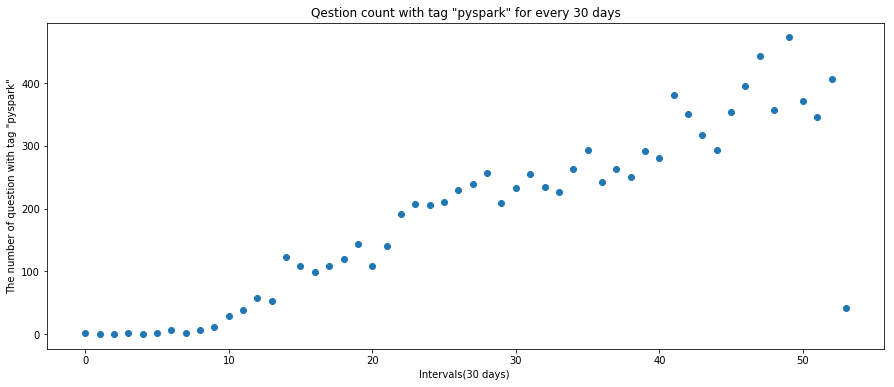

The Peason coeffient of time and question count is 0.90


In [35]:
# Convert to pandas
pd_intevel = intervel_.toPandas()

# Fill the missing intervel[1, 2, 4] with 0
size_ = pd_intevel.intervel.max()+1
x = np.arange(size_)
y = np.zeros(size_)
y[pd_intevel.intervel.values] = pd_intevel['count'].values

# Plot
plt.figure(figsize=(15,6))
plt.scatter(x,y)
plt.xlabel('Intervals(30 days) ')
plt.ylabel('The number of question with tag "pyspark"')
plt.title('Qestion count with tag "pyspark" for every 30 days')
plt.show()

# Pearson coeffient
print("The Peason coeffient of time and question count is {:0.2f}".format(np.corrcoef(x,y)[0,1]))

⬆From the figure above, we know that:
1. The scatter figure above clearly show that the number of question with tag "pyspark" grow as the time increase, and they have a linear relationship. 
2. Moreover, the Peason coeffient of time and question count is very high(0.9 >0.7), which means they have a strong relation.